# txx

DL klaar

## Modules Importeren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import optuna

2024-08-13 10:11:00.040348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Laden

In [3]:
atussum_2016 = pd.read_csv('atussum_2016.csv')
atussum_2017 = pd.read_csv('atussum_2017.csv')
atussum_2018 = pd.read_csv('atussum_2018.csv')
atussum_2019 = pd.read_csv('atussum_2019.csv')
atussum_2022 = pd.read_csv('atussum_2022.csv')

df_list = [atussum_2016, atussum_2017, atussum_2018, atussum_2019]

combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df.head())

print(combined_df.shape)

         TUCASEID     TUFINLWGT  TRYHHCHILD  TEAGE  TESEX  PEEDUCA  PTDTRACE  \
0  20160101160045  2.458865e+07          -1     62      2       39         1   
1  20160101160066  5.445941e+06          -1     69      1       37         2   
2  20160101160069  8.782622e+06           0     24      2       39         2   
3  20160101160083  3.035910e+06           8     31      2       40         1   
4  20160101160084  6.978586e+06          -1     59      2       39         1   

   PEHSPNON  GTMETSTA  TELFS  ...  t119999  t130115  t130123  t130399  \
0         2         1      5  ...      NaN      NaN      NaN      NaN   
1         2         2      5  ...      NaN      NaN      NaN      NaN   
2         2         1      5  ...      NaN      NaN      NaN      NaN   
3         2         2      1  ...      NaN      NaN      NaN      NaN   
4         2         1      1  ...      NaN      NaN      NaN      NaN   

   t130402  t150899  t019999  t060402  t090302  t180599  
0      NaN      NaN   

## Data Preparation

In [4]:
asum1 = combined_df[(combined_df['TRERNWA'] != -1)]
asum1.loc[:, 'TRERNWA'] = asum1['TRERNWA'] / 100
df = asum1.fillna(0)


def sum_columns_with_prefix(df, prefix):
    cols_to_sum = [col for col in df.columns if col.startswith(prefix)]
    if cols_to_sum:
        return df[cols_to_sum].sum(axis=1)
    else:
        return pd.Series([0] * len(df), index=df.index)

prefixes = ['t01', 't02',  't03', 't04', 't05', 't06', 't07', 't08',  't09', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 't18']

sum_columns_dict = {}
for prefix in prefixes:
    sum_columns_dict[f'{prefix}_sum'] = sum_columns_with_prefix(df, prefix)

columns_to_retain = ['TRYHHCHILD', 'TEAGE', 'TESEX','PEEDUCA', 'PTDTRACE', 'PEHSPNON', 'GTMETSTA',
'TELFS', 'TEMJOT', 'TRDPFTPT', 'TESCHENR', 'TESCHLVL', 'TRSPPRES', 'TESPEMPNOT', 'TRERNWA', 'TRCHILDNUM', 'TRSPFTPT', 'TEHRUSLT']

sum_df = pd.DataFrame(sum_columns_dict)
sum_df[columns_to_retain] = df[columns_to_retain]
df= sum_df

print(df.shape)
df.head()

(21361, 35)


,t01_sum,t02_sum,t03_sum,t04_sum,t05_sum,t06_sum,t07_sum,t08_sum,t09_sum,t10_sum,...,TEMJOT,TRDPFTPT,TESCHENR,TESCHLVL,TRSPPRES,TESPEMPNOT,TRERNWA,TRCHILDNUM,TRSPFTPT,TEHRUSLT
3,655.0,395.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2,2,-1,3,-1,469.44,3,-1,32
4,580.0,250.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,...,1,2,-1,-1,1,2,302.50,0,-1,12
10,838.0,120.0,287.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,2,-1,1,1,1538.46,2,1,55
11,555.0,20.0,40.0,0.0,480.0,0.0,0.0,0.0,15.0,0.0,...,2,1,-1,-1,2,2,1211.53,2,-1,38
12,670.0,390.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,2,-1,3,-1,961.53,0,-1,40


In [5]:
df2022 = atussum_2022[(atussum_2022['TRERNWA'] != -1)]
df2022.loc[:, 'TRERNWA'] = df2022['TRERNWA'] / 100
df2022 = df2022.fillna(0)


def sum_columns_with_prefix(df, prefix):
    cols_to_sum = [col for col in df.columns if col.startswith(prefix)]
    if cols_to_sum:
        return df[cols_to_sum].sum(axis=1)
    else:
        return pd.Series([0] * len(df), index=df.index)


sum_columns_dict = {}
for prefix in prefixes:
    sum_columns_dict[f'{prefix}_sum'] = sum_columns_with_prefix(df2022, prefix)

sum_df = pd.DataFrame(sum_columns_dict)
sum_df[columns_to_retain] = df2022[columns_to_retain]
df2022= sum_df


print(df2022.shape)
df2022.head()

(4226, 35)


,t01_sum,t02_sum,t03_sum,t04_sum,t05_sum,t06_sum,t07_sum,t08_sum,t09_sum,t10_sum,...,TEMJOT,TRDPFTPT,TESCHENR,TESCHLVL,TRSPPRES,TESPEMPNOT,TRERNWA,TRCHILDNUM,TRSPFTPT,TEHRUSLT
1,940,35,0,0,0,0,0,0,0,0,...,2,1,2,-1,1,1,640.00,0,1,40
7,570,250,0,0,0,0,30,0,0,0,...,2,1,-1,-1,3,-1,1750.00,1,-1,55
8,1397,3,0,0,0,0,0,0,0,0,...,2,1,-1,-1,1,1,769.23,0,1,40
10,420,0,0,0,0,0,0,0,0,0,...,2,1,2,-1,1,1,520.00,0,2,40
15,390,10,688,0,0,0,5,0,0,0,...,2,1,2,-1,2,2,1615.38,1,-1,50


In [6]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train = train_set.drop("TRERNWA", axis=1)
y_train = train_set["TRERNWA"]
X_test = test_set.drop("TRERNWA", axis=1)
y_test = test_set["TRERNWA"]

In [7]:
X_2022 = df2022.drop("TRERNWA", axis=1)
y_2022 = df2022["TRERNWA"]

## Modellen

### Klassieke Statistische Modellen

#### Lineaire Regressie


Test MAE: 435.44601325042964
R2 Score: 0.4264576141852219
______

2022 MAE: 487.8156413639226
2022 R2 Score: 0.3504692022040984



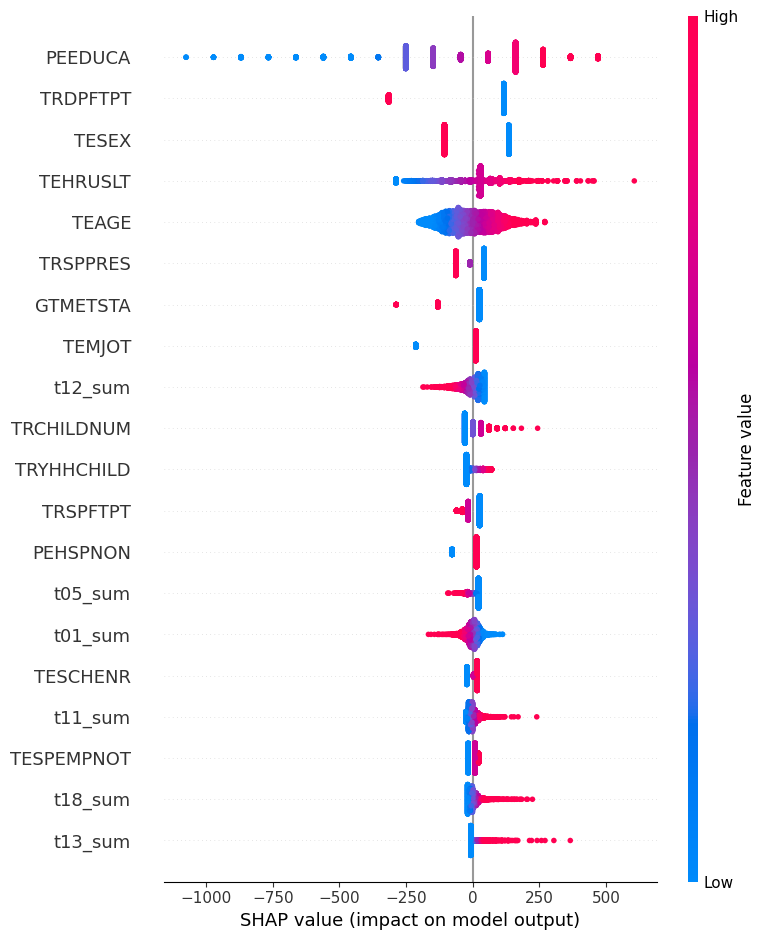

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Ridge Regressie

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 435.4284710000081
R2 Score: 0.42634103532652456
______

2022 MAE: 487.7932204646689
2022 R2 Score: 0.35011368591262704



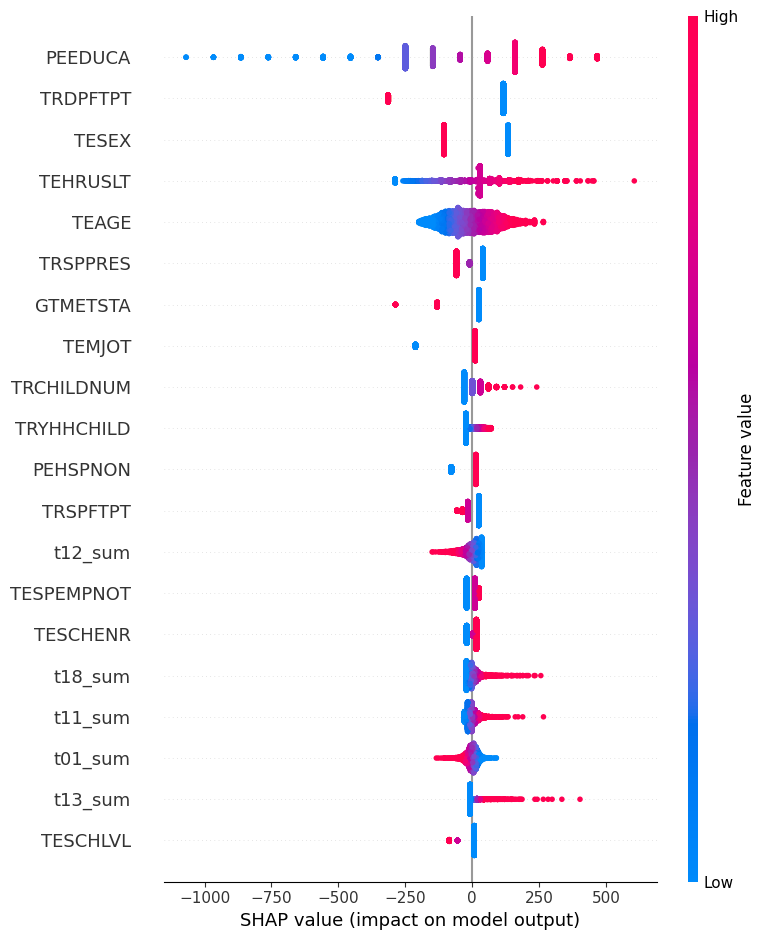

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

ridge_model = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_scaled, y_train)

y_pred = best_ridge_model.predict(X_test_scaled)
y_pred2022 = best_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Lasso Regressie

Beste hyperparameters: {'alpha': 1.0}

Test MAE: 435.440177367742
R2 Score: 0.4261573507266988
______

2022 MAE: 487.6462817600201
2022 R2 Score: 0.3505908273248355



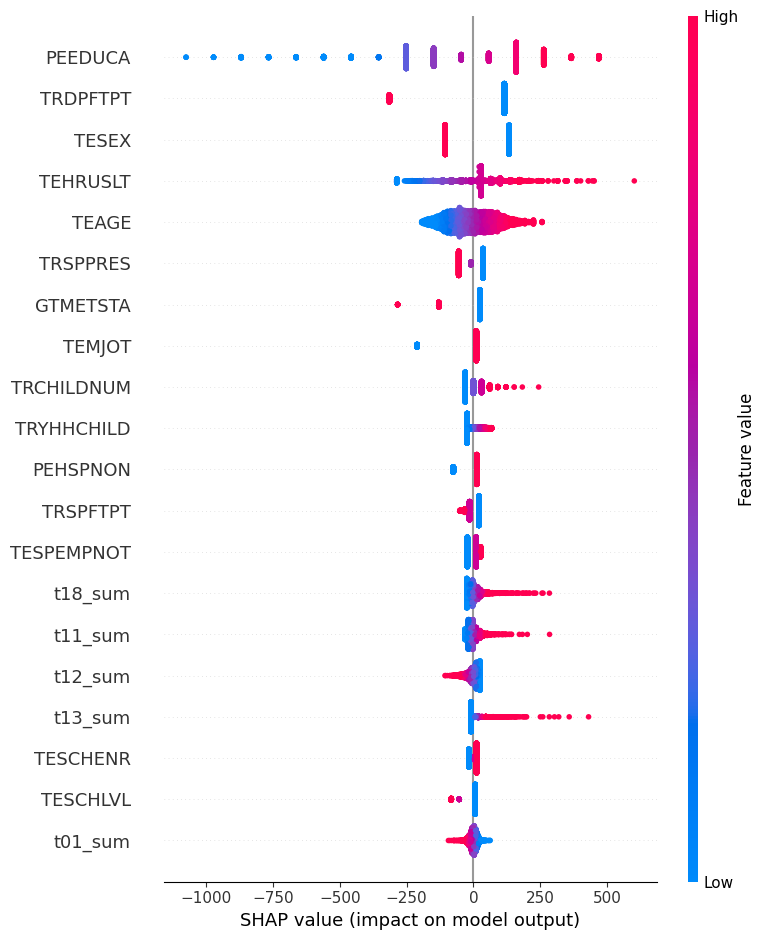

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

lasso_model = Lasso()
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_scaled, y_train)

y_pred = best_lasso_model.predict(X_test_scaled)
y_pred2022 = best_lasso_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Bayesian Ridge Regression


Test MAE: 435.43540014183213
R2 Score: 0.4263717378719224
______

2022 MAE: 487.7980073196863
2022 R2 Score: 0.3502183410726226



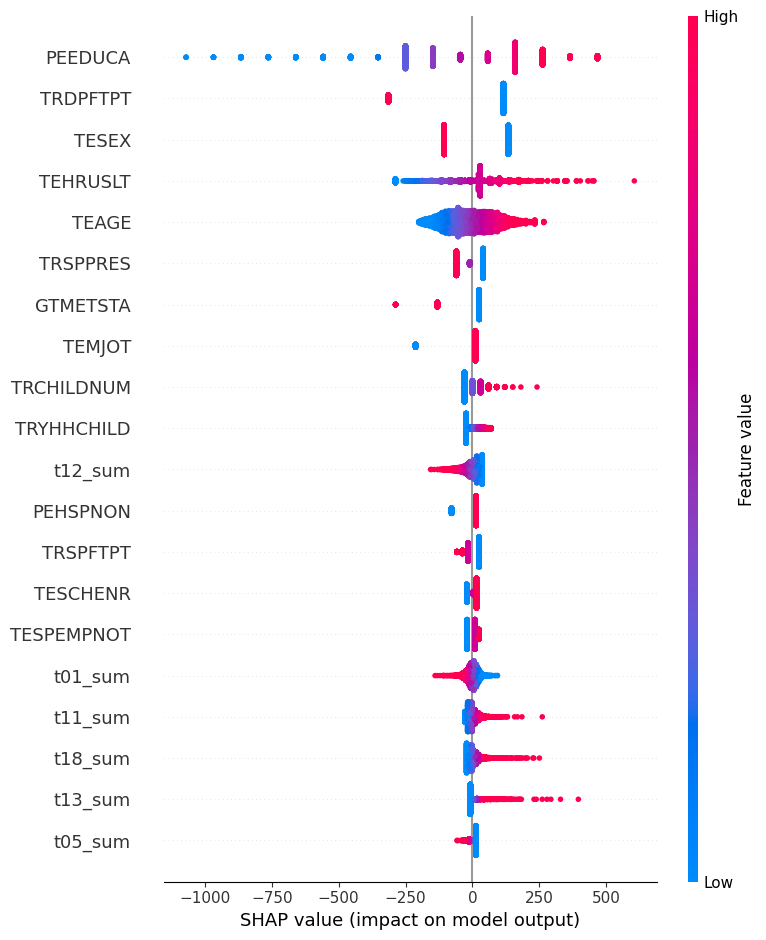

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)

y_pred = bayesian_ridge_model.predict(X_test_scaled)
y_pred2022 = bayesian_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

### Machine Learning Modellen

#### Decision Tree

Beste hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}

Test MAE: 407.0198896488573
R2 Score: 0.4464706896137469
______

2022 MAE: 457.39392186687115
2022 R2 Score: 0.38477424043026587



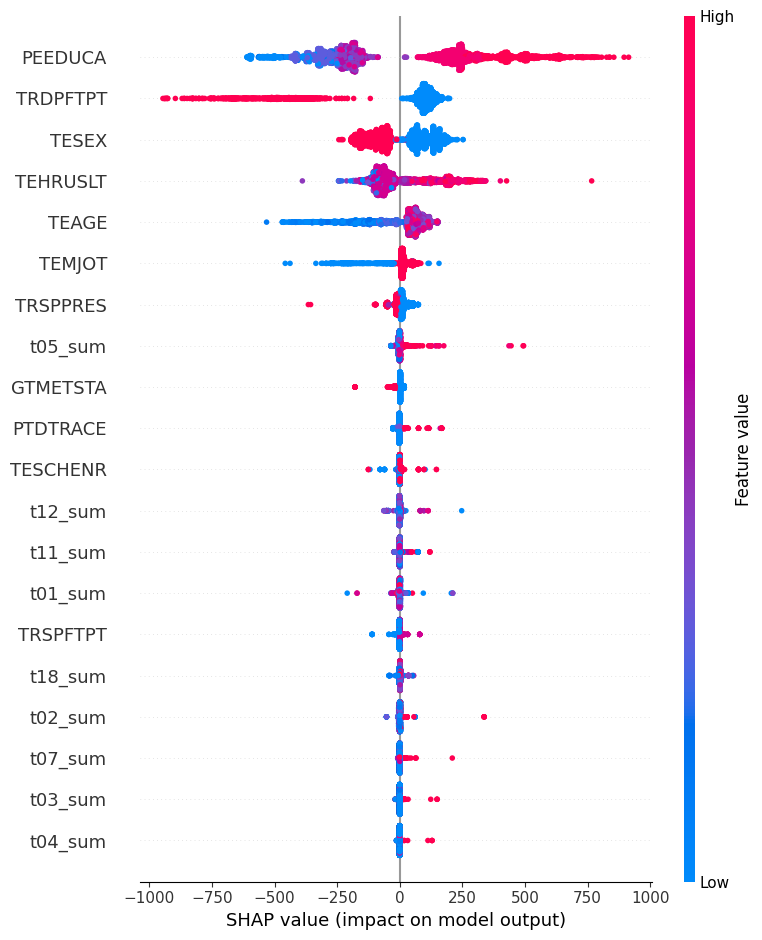

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_scaled, y_train)

y_pred = best_tree_model.predict(X_test_scaled)
y_pred2022 = best_tree_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Random Forests

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Test MAE: 391.73612165888096
R2 Score: 0.49169791672727925
______

2022 MAE: 441.95208118538727
2022 R2 Score: 0.4202537864935345



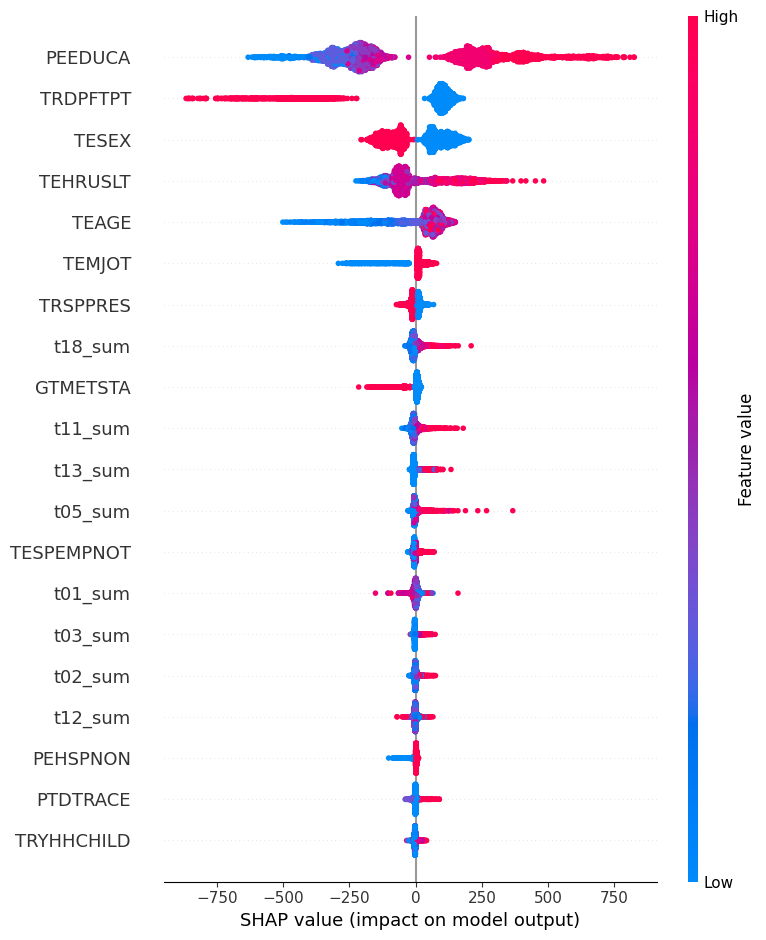

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

rf_model = RandomForestRegressor(random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred2022 = best_rf_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_rf_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

#### Gradient Boosting Machines (GBM)

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Test MAE: 383.62899466858084
R2 Score: 0.5136534995628861
______

2022 MAE: 437.64140493584614
2022 R2 Score: 0.43501392530555927



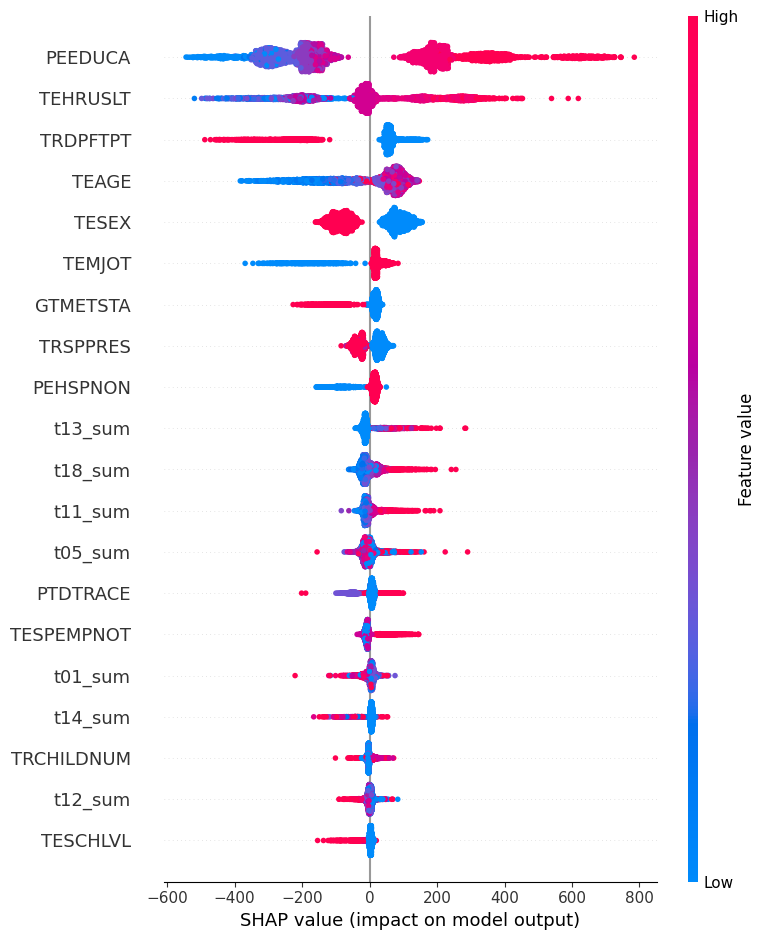

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

gbr_model = GradientBoostingRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_scaled, y_train)

y_pred = best_gbr_model.predict(X_test_scaled)
y_pred2022 = best_gbr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

#### Support Vector Machines (SVM)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

svr_model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_scaled, y_train)

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}


SVR(C=100, epsilon=1)


Test MAE: 391.014212041772
R2 Score: 0.4542888335948828
______

2022 MAE: 480.5910924026811
2022 R2 Score: 0.2960713912117169



  0%|          | 0/100 [00:00<?, ?it/s]

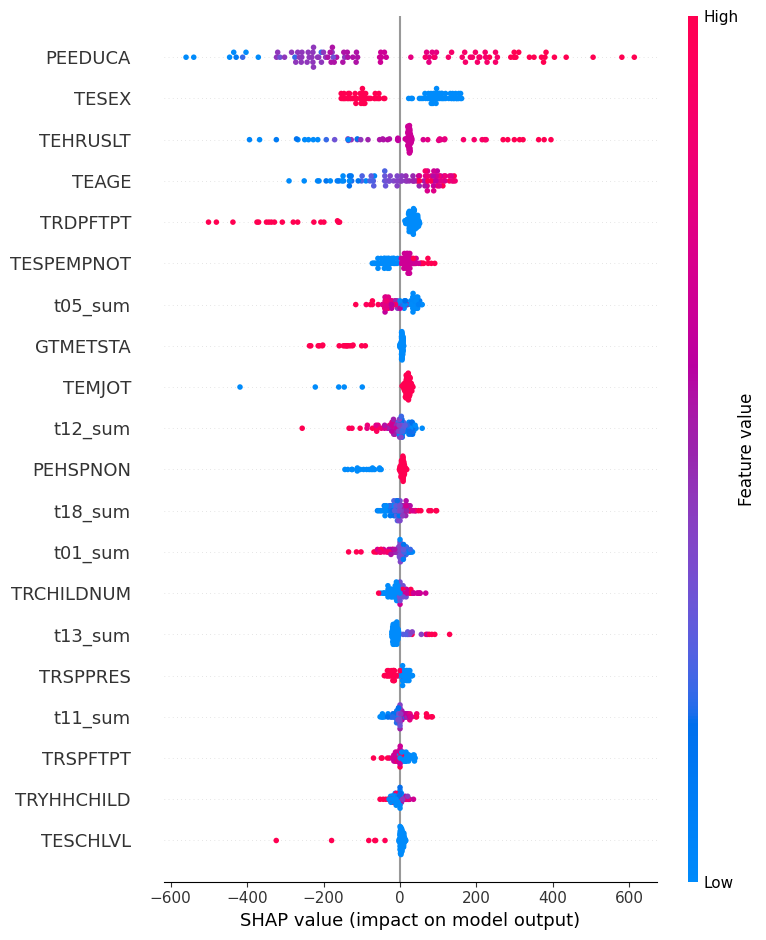

In [14]:
y_pred = best_svr_model.predict(X_test_scaled)
y_pred2022 = best_svr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

background = shap.kmeans(X_train_scaled, 50)  # Verminder aantal clusters
subset_size = 100
X_test_scaled_subset, y_test_subset = shuffle(X_test_scaled, y_test, random_state=1, n_samples=subset_size)

explainer = shap.KernelExplainer(best_svr_model.predict, background)
shap_values_test = explainer.shap_values(X_test_scaled_subset)

shap.summary_plot(shap_values_test, X_test_scaled_subset, feature_names=X_train.columns)
plt.show()

#### K-Nearest Neighbors (KNN)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_scaled, y_train)

Beste hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'}


KNeighborsRegressor(n_neighbors=11, weights='distance')

In [16]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

y_pred = best_knn_model.predict(X_test_scaled)
y_pred2022 = best_knn_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")


Test MAE: 444.54614014257277
R2 Score: 0.3751940548596846
______

2022 MAE: 490.38899597359267
2022 R2 Score: 0.31210559720704445



### Deep Learning Modellen

Epoch 1/100


2024-08-13 10:27:10.560857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


428/428 [==============================] - 1s 1ms/step - loss: 1184750.8750 - mae: 835.0508 - val_loss: 419203.2812 - val_mae: 467.8126
Epoch 2/100
428/428 [==============================] - 0s 1ms/step - loss: 344893.3125 - mae: 434.5136 - val_loss: 323642.2188 - val_mae: 424.0753
Epoch 3/100
428/428 [==============================] - 0s 1ms/step - loss: 318454.7188 - mae: 420.1228 - val_loss: 315715.4375 - val_mae: 418.2968
Epoch 4/100
428/428 [==============================] - 0s 1ms/step - loss: 312125.2500 - mae: 415.7628 - val_loss: 312958.6875 - val_mae: 416.5467
Epoch 5/100
428/428 [==============================] - 0s 1ms/step - loss: 308836.3438 - mae: 412.7220 - val_loss: 310946.1875 - val_mae: 413.7635
Epoch 6/100
428/428 [==============================] - 0s 1ms/step - loss: 305999.0625 - mae: 410.9504 - val_loss: 309327.3438 - val_mae: 410.9359
Epoch 7/100
428/428 [==============================] - 0s 1ms/step - loss: 304145.6562 - mae: 408.9846 - val_loss: 308141.0312 - 

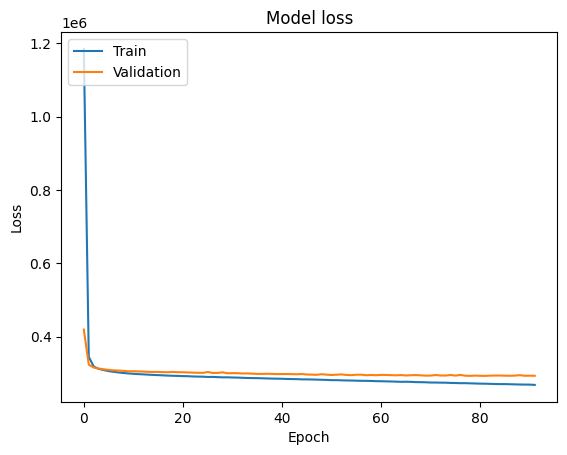

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

PermutationExplainer explainer: 4274it [01:53, 34.30it/s]                       


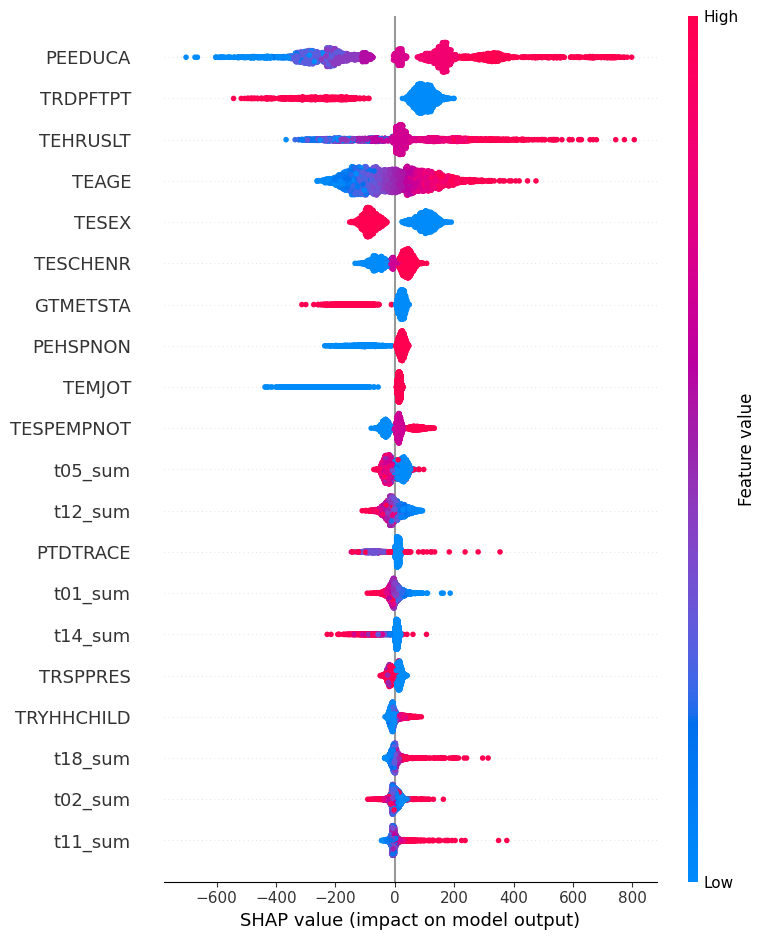

In [9]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Random Search

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

class IncomePredictionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

tuner = RandomSearch(
    IncomePredictionHyperModel(),
    objective='val_mae',
    max_trials=10,  
    executions_per_trial=2, 
    directory='my_dir',
    project_name='income_prediction8'
)

tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[EarlyStopping(patience=10)])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Trial 10 Complete [00h 00m 56s]
val_mae: 393.86492919921875

Best val_mae So Far: 392.44091796875
Total elapsed time: 00h 07m 37s
Epoch 1/50
214/214 [==============================] - 1s 3ms/step - loss: 541168.0000 - mae: 532.4191 - val_loss: 315153.0000 - val_mae: 414.2829
Epoch 2/50
214/214 [==============================] - 1s 3ms/step - loss: 313162.5938 - mae: 412.7592 - val_loss: 306179.3438 - val_mae: 409.2303
Epoch 3/50
214/214 [==============================] - 1s 3ms/step - loss: 304691.5000 - mae: 406.4688 - val_loss: 311374.0625 - val_mae: 419.8627
Epoch 4/50
214/214 [==============================] - 1s 3ms/step - loss: 299289.0312 - mae: 403.3806 - val_loss: 301415.8750 - val_mae: 406.1400
Epoch 5/50
214/214 [==============================] - 1s 3ms/step - loss: 295644.7500 - mae: 400.0863 - val_loss: 302161.4062 - val_mae: 406.8433
Epoch 6/50
214/214 [==============================] - 1s 3ms/step - loss: 292928.1250 - mae: 398.0743 - val_loss: 301503.0312 - val_mae: 398

PermutationExplainer explainer: 4274it [07:24,  9.38it/s]                       


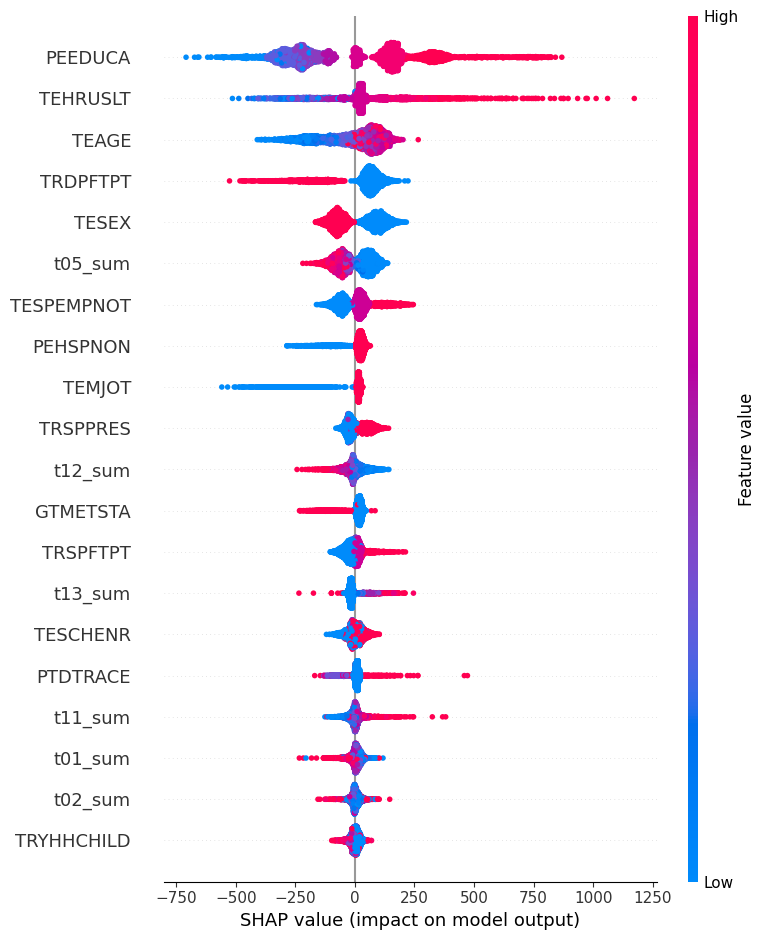

In [11]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Optuna

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

def create_model(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 16, 128, step=16)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_shape=(X_train_scaled.shape[1],)))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation=activation))

    model.add(Dense(1))

    optimizer = optimizer_name
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)


y_pred = best_model.predict(X_test_scaled)
y_pred2022 = best_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

[I 2024-08-13 10:45:05,286] A new study created in memory with name: no-name-7526186c-69d6-4e5e-bdb0-066f64b56237


134/134 [==============================] - 0s 575us/step


[I 2024-08-13 10:45:16,886] Trial 0 finished with value: 1026.0454464622458 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 2.2429435902978533e-05}. Best is trial 0 with value: 1026.0454464622458.


134/134 [==============================] - 0s 635us/step


[I 2024-08-13 10:45:33,118] Trial 1 finished with value: 396.93935615287575 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00035579444437142604}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 567us/step


[I 2024-08-13 10:45:41,580] Trial 2 finished with value: 397.2748504299072 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.008819412218203463}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 658us/step


[I 2024-08-13 10:45:52,295] Trial 3 finished with value: 402.6142574403952 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.005655076107687948}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 593us/step


[I 2024-08-13 10:46:04,508] Trial 4 finished with value: 398.69329775038244 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0013718179814346}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 718us/step


[I 2024-08-13 10:46:20,617] Trial 5 finished with value: 410.85096121982866 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 5.233297488736432e-05}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 903us/step


[I 2024-08-13 10:46:34,992] Trial 6 finished with value: 1033.9437006119383 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 1.3671406109747588e-05}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 10:46:48,775] Trial 7 finished with value: 972.2761144143225 and parameters: {'num_layers': 1, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 9.841848005080017e-05}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 835us/step


[I 2024-08-13 10:47:07,808] Trial 8 finished with value: 435.2995391360943 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0012281762302784936}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 835us/step


[I 2024-08-13 10:47:21,489] Trial 9 finished with value: 1042.1289005994504 and parameters: {'num_layers': 1, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 1.1090564054983899e-05}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 780us/step


[I 2024-08-13 10:47:35,426] Trial 10 finished with value: 408.21205346869664 and parameters: {'num_layers': 3, 'num_units': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0003312197772379364}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 767us/step


[I 2024-08-13 10:47:47,179] Trial 11 finished with value: 397.1957827056378 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006809830072368636}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 10:48:00,806] Trial 12 finished with value: 400.3803477492311 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0015063338516695336}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 812us/step


[I 2024-08-13 10:48:15,000] Trial 13 finished with value: 424.3255113836476 and parameters: {'num_layers': 1, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0002964413608262207}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 650us/step


[I 2024-08-13 10:48:28,968] Trial 14 finished with value: 397.9315430500254 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0036433171014865337}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 796us/step


[I 2024-08-13 10:48:43,901] Trial 15 finished with value: 403.88750008277526 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00046289006709963003}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 728us/step


[I 2024-08-13 10:49:01,614] Trial 16 finished with value: 405.7659619943381 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 6.817020633096573e-05}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 618us/step


[I 2024-08-13 10:49:13,322] Trial 17 finished with value: 399.9257996506918 and parameters: {'num_layers': 1, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0028731953794664407}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 700us/step


[I 2024-08-13 10:49:26,280] Trial 18 finished with value: 410.7503223753612 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.00013987478925989288}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 635us/step


[I 2024-08-13 10:49:39,095] Trial 19 finished with value: 400.4033989266526 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0007266213205110022}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 676us/step


[I 2024-08-13 10:49:52,698] Trial 20 finished with value: 406.8352191957723 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00017317985898268249}. Best is trial 1 with value: 396.93935615287575.


134/134 [==============================] - 0s 598us/step


[I 2024-08-13 10:50:02,080] Trial 21 finished with value: 395.3671824181769 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.008629688579831544}. Best is trial 21 with value: 395.3671824181769.


134/134 [==============================] - 0s 688us/step


[I 2024-08-13 10:50:10,861] Trial 22 finished with value: 395.3752434273579 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00927932954876654}. Best is trial 21 with value: 395.3671824181769.


134/134 [==============================] - 0s 716us/step


[I 2024-08-13 10:50:19,700] Trial 23 finished with value: 395.6919135841854 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0029359755532316397}. Best is trial 21 with value: 395.3671824181769.


134/134 [==============================] - 0s 841us/step


[I 2024-08-13 10:50:32,874] Trial 24 finished with value: 393.52521427814276 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003240272554054812}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 632us/step


[I 2024-08-13 10:50:44,527] Trial 25 finished with value: 398.6324879223721 and parameters: {'num_layers': 1, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00926850360698008}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 685us/step


[I 2024-08-13 10:50:56,327] Trial 26 finished with value: 394.85152268145254 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0033194968528547455}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 594us/step


[I 2024-08-13 10:51:07,640] Trial 27 finished with value: 395.52278645135806 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004706907440306445}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 605us/step


[I 2024-08-13 10:51:18,524] Trial 28 finished with value: 402.9635713485407 and parameters: {'num_layers': 1, 'num_units': 64, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.002421885142773466}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 665us/step


[I 2024-08-13 10:51:30,771] Trial 29 finished with value: 550.5053088426669 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0007731801341861397}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 647us/step


[I 2024-08-13 10:51:42,126] Trial 30 finished with value: 397.1636455744612 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0021538599577735004}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 619us/step


[I 2024-08-13 10:51:51,237] Trial 31 finished with value: 396.47981454454197 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0052735579007995685}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 638us/step


[I 2024-08-13 10:51:57,820] Trial 32 finished with value: 397.76837145811834 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.009199331735587882}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 659us/step


[I 2024-08-13 10:52:09,408] Trial 33 finished with value: 395.7131992924121 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004299665912687655}. Best is trial 24 with value: 393.52521427814276.


134/134 [==============================] - 0s 669us/step


[I 2024-08-13 10:52:19,307] Trial 34 finished with value: 391.3324809625806 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006700848979373365}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 539us/step


[I 2024-08-13 10:52:28,610] Trial 35 finished with value: 394.53578995582563 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006344337899091758}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 632us/step


[I 2024-08-13 10:52:41,287] Trial 36 finished with value: 395.0224106963658 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0017335029279006806}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 679us/step


[I 2024-08-13 10:52:53,562] Trial 37 finished with value: 487.71960164830523 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.001023124578865687}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 777us/step


[I 2024-08-13 10:52:59,423] Trial 38 finished with value: 397.3531364910859 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.005925271279202764}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 767us/step


[I 2024-08-13 10:53:08,850] Trial 39 finished with value: 392.8585237157649 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.003891138760778346}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 835us/step


[I 2024-08-13 10:53:24,782] Trial 40 finished with value: 428.8889986690179 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001963917388732705}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 734us/step


[I 2024-08-13 10:53:35,249] Trial 41 finished with value: 393.3937109926002 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0034857914270388177}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 724us/step


[I 2024-08-13 10:53:44,343] Trial 42 finished with value: 392.6636270897935 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.006390131095340945}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 908us/step


[I 2024-08-13 10:53:54,211] Trial 43 finished with value: 399.8601466731726 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.00393508257981454}. Best is trial 34 with value: 391.3324809625806.


134/134 [==============================] - 0s 813us/step


[I 2024-08-13 10:54:04,381] Trial 44 finished with value: 388.64836092925924 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.005582863617757945}. Best is trial 44 with value: 388.64836092925924.


134/134 [==============================] - 0s 792us/step


[I 2024-08-13 10:54:18,604] Trial 45 finished with value: 577.7684284163337 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 2.959925663400339e-05}. Best is trial 44 with value: 388.64836092925924.


134/134 [==============================] - 0s 701us/step


[I 2024-08-13 10:54:26,184] Trial 46 finished with value: 404.90732592532044 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.006656153920276254}. Best is trial 44 with value: 388.64836092925924.


134/134 [==============================] - 0s 832us/step


[I 2024-08-13 10:54:34,063] Trial 47 finished with value: 395.312384950516 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004906877466673492}. Best is trial 44 with value: 388.64836092925924.


134/134 [==============================] - 0s 906us/step


[I 2024-08-13 10:54:46,731] Trial 48 finished with value: 401.24132526982453 and parameters: {'num_layers': 1, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0023068642229346725}. Best is trial 44 with value: 388.64836092925924.


134/134 [==============================] - 0s 771us/step


[I 2024-08-13 10:55:01,021] Trial 49 finished with value: 398.1384831901638 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0010589172076803618}. Best is trial 44 with value: 388.64836092925924.


FrozenTrial(number=44, state=TrialState.COMPLETE, values=[388.64836092925924], datetime_start=datetime.datetime(2024, 8, 13, 10, 53, 54, 211923), datetime_complete=datetime.datetime(2024, 8, 13, 10, 54, 4, 381033), params={'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.005582863617757945}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'num_units': IntDistribution(high=128, log=False, low=16, step=16), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None)}, trial_id=44, value=None)
133/133 [==============================] - 0s 758us/step


Test MAE: 394.15192355948255
R2 Score: 0.4871008456873196

______
2022 MAE: 451.4978408289565
2022 R2 Score: 0.4001817295285772


PermutationExplainer explainer: 4274it [01:56, 33.44it/s]                       


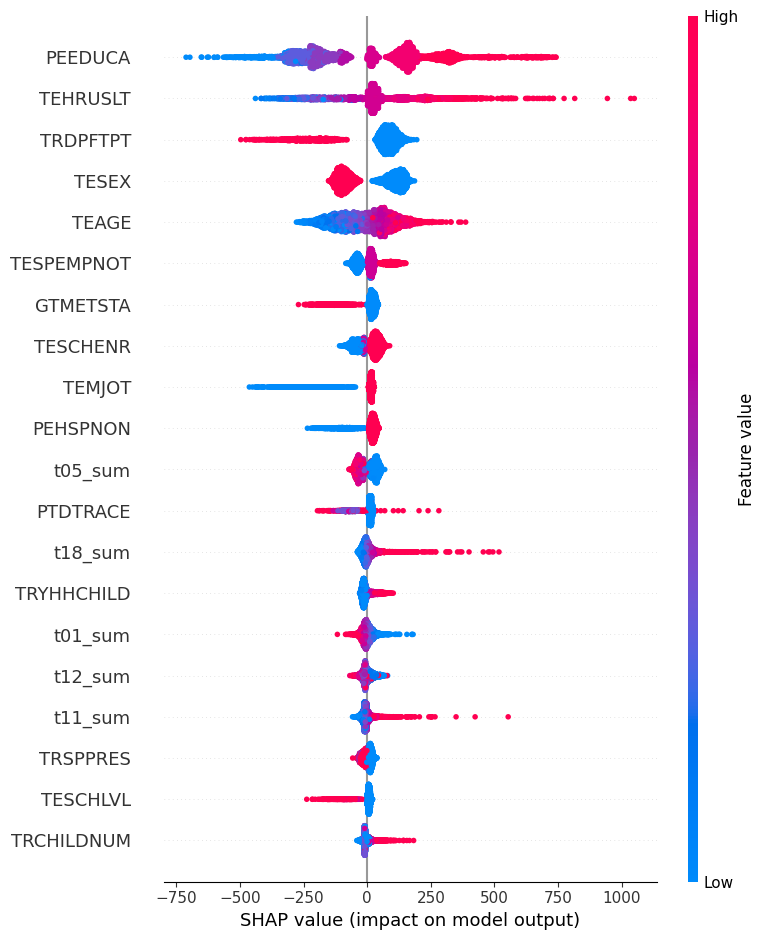

In [13]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

### 1D Convolutional Neural Network

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Epoch 1/100
428/428 [==============================] - 1s 2ms/step - loss: 843297.0625 - mae: 700.4660 - val_loss: 552164.7500 - val_mae: 589.5422
Epoch 2/100
428/428 [==============================] - 1s 2ms/step - loss: 528607.8125 - mae: 572.6314 - val_loss: 473884.8125 - val_mae: 534.0526
Epoch 3/100
428/428 [==============================] - 1s 2ms/step - loss: 446436.0625 - mae: 519.8024 - val_loss: 399754.9688 - val_mae: 487.6719
Epoch 4/100
428/428 [==============================] - 1s 2ms/step - loss: 404559.9375 - mae: 488.4880 - val_loss: 374406.2188 - val_mae: 463.2368
Epoch 5/100
428/428 [==============================] - 1s 2ms/step - loss: 393752.9688 - mae: 482.7027 - val_loss: 366655.2812 - val_mae: 456.7416
Epoch 6/100
428/428 [==============================] - 1s 2ms/step - loss: 386606.2500 - mae: 477.5582 - val_loss: 361734.3750 - val_mae: 452.2892
Epoch 7/100
428/428 [==============================] - 1s 2ms/step - loss: 382230.0625 - mae: 475.1462 - val_loss: 357

#### Hyperparameter Tuning: Optuna

In [15]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_2022_cnn = X2022_scaled.reshape((X2022_scaled.shape[0], X2022_scaled.shape[1], 1))

def create_model(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    filters = trial.suggest_int('filters', 16, 128, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 128, step=16)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same', input_shape=(X_train_cnn.shape[1], 1)))

    for _ in range(num_conv_layers - 1):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_cnn)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

[I 2024-08-13 10:58:49,938] A new study created in memory with name: no-name-a1ddadea-a086-49f8-bb57-55d3d13ae22f


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 11:01:58,290] Trial 0 finished with value: 555.9889205401971 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.37542614260138635, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 1.196493933021538e-05}. Best is trial 0 with value: 555.9889205401971.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:02:47,440] Trial 1 finished with value: 397.9107363196689 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.16819388979826527, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0006048305219752996}. Best is trial 1 with value: 397.9107363196689.


134/134 [==============================] - 0s 953us/step


[I 2024-08-13 11:03:00,803] Trial 2 finished with value: 398.6701347737097 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3540273830093576, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.008124720202098836}. Best is trial 1 with value: 397.9107363196689.


134/134 [==============================] - 1s 4ms/step


[I 2024-08-13 11:06:33,255] Trial 3 finished with value: 665.7693752419694 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.15884064388544422, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.0013053211327527312}. Best is trial 1 with value: 397.9107363196689.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:07:20,457] Trial 4 finished with value: 570.6128717713789 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.02857324452359511, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0003706637771395152}. Best is trial 1 with value: 397.9107363196689.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:08:32,673] Trial 5 finished with value: 390.22941932098274 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4075614073454911, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.002461687142917476}. Best is trial 5 with value: 390.22941932098274.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:10:27,966] Trial 6 finished with value: 529.5471860401841 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.39681641058035266, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 1.7393465767364863e-05}. Best is trial 5 with value: 390.22941932098274.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:11:44,639] Trial 7 finished with value: 505.50839948129686 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2424444933343579, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 1.591379327984979e-05}. Best is trial 5 with value: 390.22941932098274.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:12:34,992] Trial 8 finished with value: 592.5533363744735 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.20007359028955907, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.006303807692443904}. Best is trial 5 with value: 390.22941932098274.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 11:15:12,199] Trial 9 finished with value: 954.4619769099991 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.32966382588355914, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 3.94883979809167e-05}. Best is trial 5 with value: 390.22941932098274.


134/134 [==============================] - 0s 794us/step


[I 2024-08-13 11:15:54,466] Trial 10 finished with value: 387.39965211946406 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4619542420984899, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.002181116107561402}. Best is trial 10 with value: 387.39965211946406.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:16:37,945] Trial 11 finished with value: 380.08404999936295 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.48493960028521893, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.002024406496398506}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 11:17:26,147] Trial 12 finished with value: 413.9723768104973 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4944325266860536, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.00010340039191254317}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:18:12,723] Trial 13 finished with value: 395.2690408812991 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.466214817004747, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0024746892856609796}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:19:03,694] Trial 14 finished with value: 394.75258398862184 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.45092255371965984, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0009657206324930452}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:19:56,984] Trial 15 finished with value: 397.6174984009875 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.29687542359059144, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.00019565319518126498}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:20:47,113] Trial 16 finished with value: 390.0666941271781 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.07510671806097396, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0032323214364785684}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:22:00,230] Trial 17 finished with value: 422.3323236831033 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.44501549636523224, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0012148720907979246}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:22:40,420] Trial 18 finished with value: 592.7745673185921 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.28562459569311327, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.003936005164347345}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:23:39,029] Trial 19 finished with value: 398.1113463425586 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4909468736041928, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0001737395149596526}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:24:35,852] Trial 20 finished with value: 389.0760096042507 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.42713373062073906, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0005859123029352863}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:25:32,326] Trial 21 finished with value: 394.47867923496426 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.42428556850656646, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0005885685346739277}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:26:19,751] Trial 22 finished with value: 386.79396850749316 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.42215974610398976, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0014583291187515706}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:27:06,913] Trial 23 finished with value: 387.85189381100383 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4999359708375228, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0019394415404607509}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:27:49,949] Trial 24 finished with value: 399.7860248859744 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.3375598058130308, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.00470202691784114}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:28:28,537] Trial 25 finished with value: 391.41363635055365 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.38809924609490737, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0014855777130940173}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:28:53,770] Trial 26 finished with value: 592.8991273169648 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.461060031825627, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.009526664157799751}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:29:52,081] Trial 27 finished with value: 400.0720847404653 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3702757603394514, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0007723624397348797}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:30:36,762] Trial 28 finished with value: 398.9060468016379 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.30652849163499063, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.00032962757289106643}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:31:37,087] Trial 29 finished with value: 384.6385512938567 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3839926000824707, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.0018810151826255611}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 11:32:44,370] Trial 30 finished with value: 394.262797057377 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.25956633655284467, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.004496357744701335}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:33:19,010] Trial 31 finished with value: 390.5398089052536 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.38012400646534156, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0018906632332368995}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:34:00,255] Trial 32 finished with value: 394.6310937444293 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.4209375044404199, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0008547178662921776}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:34:50,107] Trial 33 finished with value: 385.61456177168475 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4655459875319315, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.002926160220155654}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:35:10,036] Trial 34 finished with value: 402.19716102241216 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3493120523289398, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.005543476270375396}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:36:14,375] Trial 35 finished with value: 387.1729977638393 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.47528642432894, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.002960006879967002}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:37:18,750] Trial 36 finished with value: 400.29223990285254 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.4296559724429433, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0013789630009380014}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:37:53,725] Trial 37 finished with value: 389.5854344523988 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4064193927781267, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.007410944155289159}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:40:01,030] Trial 38 finished with value: 392.91381246386885 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.36125815733900085, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0004924896379471291}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:40:36,120] Trial 39 finished with value: 396.9578004585193 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.1528325539133838, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.001048902143431262}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 11:43:03,193] Trial 40 finished with value: 592.4429167919842 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.3980484851086176, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0016786417687313954}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:43:44,210] Trial 41 finished with value: 391.38880336683803 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.47458655442980113, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.00318108049063428}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:44:26,702] Trial 42 finished with value: 391.99061879921095 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.47638560093123167, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0031480197178714296}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:45:04,308] Trial 43 finished with value: 393.15423637184807 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4404259954477982, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0026347465614995095}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:45:20,624] Trial 44 finished with value: 392.3096275751501 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.4995491928986416, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.0063528017446467045}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:45:45,059] Trial 45 finished with value: 393.7964207942007 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.44878735345447274, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.003987602437584453}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 914us/step


[I 2024-08-13 11:46:28,538] Trial 46 finished with value: 428.22203672389395 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.47636513723338486, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 4.9459123653569773e-05}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 823us/step


[I 2024-08-13 11:46:46,434] Trial 47 finished with value: 394.2072079269227 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.40491209274148016, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0022934740613937414}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:47:37,587] Trial 48 finished with value: 674.5864182719117 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.3258794214668259, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.0004422112079722945}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:48:15,841] Trial 49 finished with value: 415.79371188296 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4537306914172081, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.00022804304096328638}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:49:17,212] Trial 50 finished with value: 383.847121570247 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.08100304402311581, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0007562343882652533}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:50:18,411] Trial 51 finished with value: 387.81264891192586 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.0873339432176043, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0007563015327492161}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:51:27,733] Trial 52 finished with value: 389.79080111263676 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.02841397673843659, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.001188927738731215}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:52:33,591] Trial 53 finished with value: 384.65025116281043 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2082868337357012, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0018820599465490223}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 1s 3ms/step


[I 2024-08-13 11:53:44,893] Trial 54 finished with value: 380.83463102476844 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.20010557283736594, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0015360603488977938}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:54:16,049] Trial 55 finished with value: 395.1815855835518 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.19622425231225948, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.001020567464261253}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:55:26,735] Trial 56 finished with value: 401.66787131136545 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.11916476342974282, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0020878163316219263}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:56:10,658] Trial 57 finished with value: 396.14299281164267 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.24019320305675562, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0006868994598822382}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 11:58:55,858] Trial 58 finished with value: 592.359506316003 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.21500040005923016, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.001774857991499806}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:00:07,709] Trial 59 finished with value: 387.9819403261863 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.05721813320952775, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0012153603568389928}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:00:40,484] Trial 60 finished with value: 390.1760397490991 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.17485941882004027, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0038021514168709285}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:01:42,252] Trial 61 finished with value: 390.9025086464805 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.11842726405660144, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0014582488868216173}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:02:34,240] Trial 62 finished with value: 384.9268518790601 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.21824191202137516, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.002361709357485109}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:03:15,399] Trial 63 finished with value: 393.671868384906 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.21374507718069094, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.002646669266692954}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:04:08,200] Trial 64 finished with value: 391.95094933229285 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.0089062558440067, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0023132011108633384}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:04:50,538] Trial 65 finished with value: 389.48678750261115 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2730174092607745, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0050178211718772915}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:05:45,521] Trial 66 finished with value: 394.1300134624443 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.23085778064565032, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0009123104592579841}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 970us/step


[I 2024-08-13 12:06:10,433] Trial 67 finished with value: 395.9105934594438 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.1836747761687352, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0016797306153151453}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:07:02,607] Trial 68 finished with value: 391.58720432337736 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.16030707617882362, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.003682655079897209}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:08:11,402] Trial 69 finished with value: 384.6802158757269 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.134785754881076, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.002018976109461107}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:09:30,216] Trial 70 finished with value: 591.4301797716037 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.13933136628904905, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0006091918389891474}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:10:26,889] Trial 71 finished with value: 387.0540212920564 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.0950923821222192, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.002158609034158327}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:11:32,232] Trial 72 finished with value: 390.73843401793937 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.057534045523732244, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0016632757658651364}. Best is trial 11 with value: 380.08404999936295.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:12:42,881] Trial 73 finished with value: 378.3247157355089 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2551987062259779, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0010960641708931418}. Best is trial 73 with value: 378.3247157355089.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:13:46,260] Trial 74 finished with value: 392.61566470284777 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.25520695909816776, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0011320950986899482}. Best is trial 73 with value: 378.3247157355089.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:14:47,008] Trial 75 finished with value: 394.14600357735486 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1398820844757608, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.000881749319378029}. Best is trial 73 with value: 378.3247157355089.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:15:45,003] Trial 76 finished with value: 379.80775013029785 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.22277074064681465, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0013856424712605517}. Best is trial 73 with value: 378.3247157355089.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:17:10,393] Trial 77 finished with value: 387.2724699571164 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.19487285214716277, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0004239742947385181}. Best is trial 73 with value: 378.3247157355089.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:18:01,503] Trial 78 finished with value: 386.74735990153357 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2724746437449087, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0013539605333818291}. Best is trial 73 with value: 378.3247157355089.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:19:14,113] Trial 79 finished with value: 385.6345100950084 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1140316451049902, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0005631423685096867}. Best is trial 73 with value: 378.3247157355089.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:20:04,727] Trial 80 finished with value: 569.5815120315104 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.30573867314915837, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 1.2506577690045476e-05}. Best is trial 73 with value: 378.3247157355089.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:20:47,855] Trial 81 finished with value: 387.29515433952673 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.22627516147308047, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0020102821105673304}. Best is trial 73 with value: 378.3247157355089.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:21:47,337] Trial 82 finished with value: 378.2197948434563 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2089838672712566, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0015591486572944019}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:22:48,638] Trial 83 finished with value: 382.2027512842951 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.18205251445736503, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0015269985002156023}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:23:29,245] Trial 84 finished with value: 391.31270750349756 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.18179126405313703, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0009738241661779046}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:24:28,946] Trial 85 finished with value: 383.51493780120484 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.24331937668275447, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0013888303875346298}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:25:20,471] Trial 86 finished with value: 392.6096033815419 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2419707459975027, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.001438790961938165}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:26:20,578] Trial 87 finished with value: 387.6123066120429 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2631475191145233, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0007518438937629626}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:27:02,149] Trial 88 finished with value: 663.3302390366977 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.19421889322818126, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.00027245942881585215}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:28:01,411] Trial 89 finished with value: 382.79728028679295 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.28969258999236686, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0011062222421760475}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 799us/step


[I 2024-08-13 12:28:53,546] Trial 90 finished with value: 399.0666402171943 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.29218987597005913, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0001422066864638301}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:29:57,728] Trial 91 finished with value: 384.4703050072668 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.22752643887449017, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0013201897928988733}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:30:40,156] Trial 92 finished with value: 389.66641342289853 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2281479184167243, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0011660930084264993}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:31:46,670] Trial 93 finished with value: 387.371868805228 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2502595212007346, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.001629372753341349}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:33:09,312] Trial 94 finished with value: 387.2156760985529 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.20430054173866447, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0012725944003166624}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 855us/step


[I 2024-08-13 12:33:55,447] Trial 95 finished with value: 392.3937224575465 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2823441009613216, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0008353398899152723}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 816us/step


[I 2024-08-13 12:34:40,551] Trial 96 finished with value: 396.1165398053634 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.168293421727166, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0006663962570352006}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 788us/step


[I 2024-08-13 12:35:22,639] Trial 97 finished with value: 381.9909854530926 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.23931389239697065, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0010661248996618462}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 785us/step


[I 2024-08-13 12:36:06,006] Trial 98 finished with value: 405.12437093372733 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.24312106445891696, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0010616142824141383}. Best is trial 82 with value: 378.2197948434563.


134/134 [==============================] - 0s 751us/step


[I 2024-08-13 12:36:37,546] Trial 99 finished with value: 387.0160718144462 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.3252406991267523, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.00269376434013637}. Best is trial 82 with value: 378.2197948434563.


FrozenTrial(number=82, state=TrialState.COMPLETE, values=[378.2197948434563], datetime_start=datetime.datetime(2024, 8, 13, 12, 20, 47, 855925), datetime_complete=datetime.datetime(2024, 8, 13, 12, 21, 47, 336918), params={'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2089838672712566, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0015591486572944019}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_conv_layers': IntDistribution(high=3, log=False, low=1, step=1), 'filters': IntDistribution(high=128, log=False, low=16, step=16), 'kernel_size': IntDistribution(high=5, log=False, low=2, step=1), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dense_units': IntDistribution(high=128, log=False, low=16, step=16), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistri

In [16]:
y_pred = best_model.predict(X_test_cnn)
y_pred2022 = best_model.predict(X_2022_cnn)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

133/133 [==============================] - 0s 966us/step


Test MAE: 388.3981220158051
R2 Score: 0.503392759849852

______
2022 MAE: 437.710433489262
2022 R2 Score: 0.43762268659439574


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


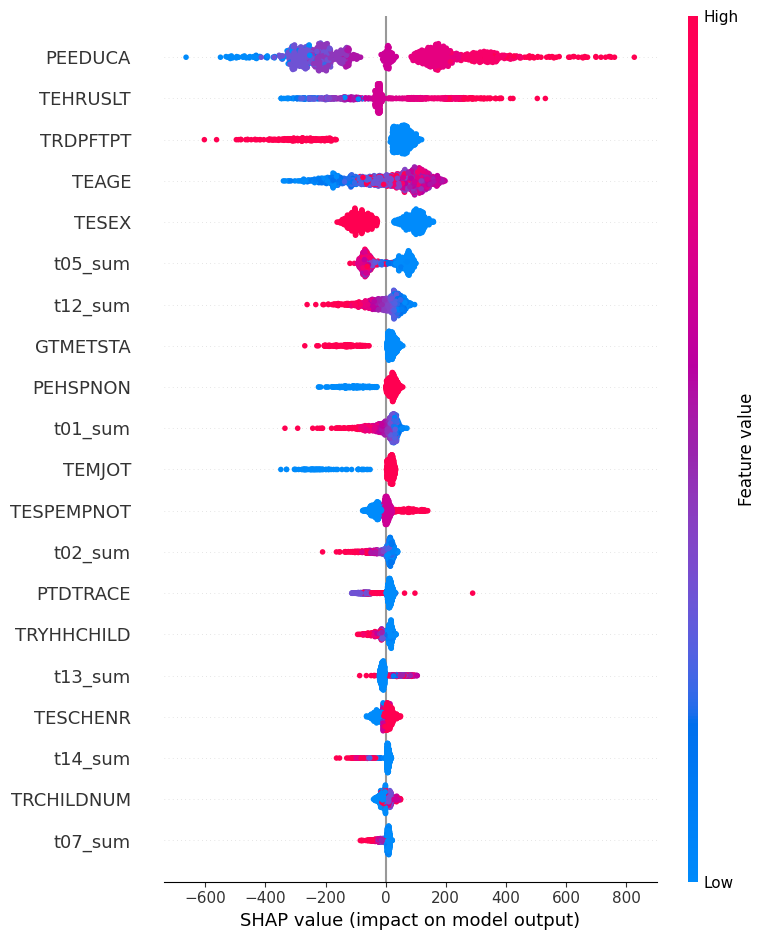

In [17]:
original_feature_names = X_train.columns.tolist()

background = X_train_cnn[np.random.choice(X_train_cnn.shape[0], 1000, replace=False)]

explainer = shap.DeepExplainer(best_model, background)

X_test_cnn_sample = X_test_cnn[np.random.choice(X_test_cnn.shape[0], 1000, replace=False)]
shap_values = explainer.shap_values(X_test_cnn_sample)

X_test_cnn_sample_2d = X_test_cnn_sample.reshape(X_test_cnn_sample.shape[0], -1)
shap_values_2d = np.array(shap_values).reshape(shap_values[0].shape[0], -1)

extended_feature_names = np.tile(original_feature_names, X_train_cnn.shape[1])

shap.summary_plot(shap_values_2d, X_test_cnn_sample_2d, feature_names=extended_feature_names)